In [1]:
from __future__ import print_function, division

In [2]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
import time
import shutil

import urllib

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [3]:
import hosts
import decals

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy import table
from astropy.table import Table
from astropy.io import fits

from astropy.utils import data

import tqdm
from IPython import display

In [4]:
%matplotlib inline
from matplotlib import style, pyplot as plt

plt.style.use('seaborn-deep')
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (14, 8)

# Load the bricks and SAGA hosts

In [5]:
bricks = Table.read('decals_dr4/survey-bricks.fits.gz')
bricksdr3 = Table.read('decals_dr3/survey-bricks-dr3.fits.gz')
bricksdr4 = Table.read('decals_dr4/survey-bricks-dr4.fits.gz')

In [10]:
hostobjs = hosts.get_saga_hosts_from_google()
for host in hostobjs:
    host.fnsdss = 'catalogs/base_sql_nsa{}.fits.gz'.format(host.nsaid)
    
hostsbyname = {h.name:h for h in hostobjs}

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [13]:
hoststogen = [hostsbyname['Alice']]

host_bricks_3 = decals.find_host_bricks(hoststogen, bricksdr3, bricks)
host_bricks_4 = decals.find_host_bricks(hoststogen, bricksdr4, bricks)

host_bricks_dct = {3:host_bricks_3, 4:host_bricks_4}

# Build combined catalogs for every host

In [14]:
for hostobj in hoststogen:
    hbricks = host_bricks_3[host_bricks_3['closest_host_name'] == hostobj.name]
    catfn = 'decals_dr3/'

In [15]:
def load_host_catalog(hostobj, drnum):
    host_bricks = host_bricks_dct[drnum]
    tabs = []
    for brick in host_bricks[host_bricks['closest_host_name'] == hostobj.name]:
        catfn = 'decals_dr{}/catalogs/tractor-{}.fits'.format(drnum, brick['brickname'])
        cat = Table.read(catfn)
        cat['objname'] = ['{}-{}'.format(row['brickname'], row['objid']) for row in cat]
        tabs.append(cat)
    if tabs:
        return table.vstack(tabs)

In [17]:
for hostobj in tqdm.tqdm_notebook(hoststogen):
    hostobj.cats3 = load_host_catalog(hostobj, 3)
    
[(hostobj.name, len(hostobj.cats3)) for hostobj in hoststogen if hostobj.cats3 is not None]

[('Alice', 237279)]

In [18]:
for hostobj in tqdm.tqdm_notebook(hoststogen):
    hostobj.cats4 = load_host_catalog(hostobj, 4)
    
[(hostobj.name, len(hostobj.cats4)) for hostobj in hoststogen if hostobj.cats4 is not None]

[]

## Compute surface brightnesses

In [19]:
for host in tqdm.tqdm_notebook(hoststogen):
    for cat in (host.cats3, host.cats4):
        if cat is not None:
            decals.mags_catalog(cat)
            decals.aperture_sbs_catalog(cat, bandname='r')
            decals.interpolate_catalog_sb(cat, loopfunc=lambda x: tqdm.tqdm_notebook(x, leave=False))

decals.py:97: RuntimeWarning: divide by zero encountered in log10
  mag = np.array(22.5 - 2.5*np.log10(flux))
decals.py:97: RuntimeWarning: invalid value encountered in log10
  mag = np.array(22.5 - 2.5*np.log10(flux))
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/astropy/units/quantity.py:885: RuntimeWarning: divide by zero encountered in power
  return super(Quantity, self).__pow__(other)
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/astropy/units/quantity.py:841: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__truediv__(other)
decals.py:132: RuntimeWarning: divide by zero encountered in log10
  return np.array(22.5 - 2.5*np.log10(apflux) + A) * u.mag * u.arcsec**-2
decals.py:132: RuntimeWarning: invalid value encountered in log10
  return np.array(22.5 - 2.5*np.log10(apflux) + A) * u.mag * u.arcsec**-2


decals.py:131: RuntimeWarning: divide by zero encountered in log10
  A = 2.5*np.log10(np.pi*(rad.to(u.arcsec).value)**2)
decals.py:132: RuntimeWarning: invalid value encountered in add
  return np.array(22.5 - 2.5*np.log10(apflux) + A) * u.mag * u.arcsec**-2


## Overall quality measures 

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in power
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in power


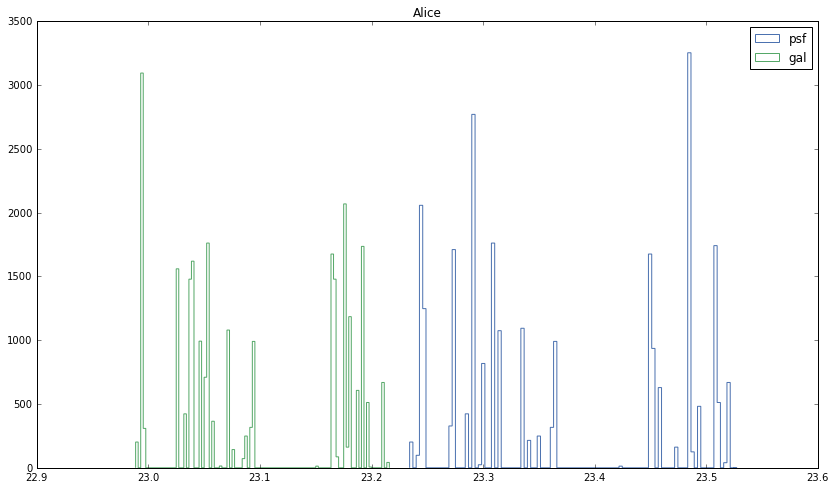

In [34]:
for host in hoststogen:
    plt.figure()
    plt.title(host.name)
    for cat in (host.cats3, host.cats4):
        if cat is not None:
            scs = SkyCoord(cat['ra'], cat['dec'], unit=u.deg)
            subcat = cat[host.within_environs(scs)]
            
            if 'decam_galdepth' in subcat.colnames:
                psfdepthr = subcat['decam_depth'][:, 2]
                galdepthr = subcat['decam_galdepth'][:, 2]
            else:
                psfdepthr = subcat['psfdepth_r']
                galdepthr = subcat['galdepth_r']
            psfdepths =-2.5*(np.log10(5*psfdepthr**-0.5)-9)
            galdepths =-2.5*(np.log10(5*galdepthr**-0.5)-9)
            
            plt.hist(psfdepths[np.isfinite(psfdepths)], bins=100, histtype='step', label='psf')
            plt.hist(galdepths[np.isfinite(galdepths)], bins=100, histtype='step', label='gal')
        plt.legend()

In [38]:
for host in hoststogen:
    for cat, dr in zip((host.cats3, host.cats4), (3,4)):
        if cat is not None:
            fn = 'catalogs/{}_decals_dr{}.fits'.format(host.name, dr)
            print('writing', fn)
            cat.write(fn, format='fits')